# Inference: No-U-Turn (NUTS) MCMC

This example shows you how to perform Bayesian inference on a time-series problem, using [No-U-Turn Monte Carlo](http://pints.readthedocs.io/en/latest/mcmc_samplers/nuts_mcmc.html). The same inference problem is also setup using [Hamiltonian MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/hamiltonian_mcmc.html), which is a similar method but without the adaptive stepping that is part of NUTS


First, we setup a problem using the logistic growth toy problem

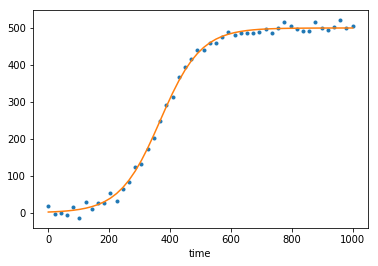

In [5]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = np.array([0.015, 500])
times = np.linspace(0, 1000, 50)
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.plot(times, values, '.')
plt.plot(times, org_values)
plt.xlabel('time')
plt.show()

Now we set up and run a sampling routine using No-U-Turn MCMC

Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     15     0.333    1       0.333    1       0        2        0:00.0
1     18     0        1       0        1       0        1        0:00.0
2     21                                       0.5      1        0:00.0
3     30     0.429    2       0.277299 2       0.5      2        0:00.0
100   759    0.593    3       0.597    3       0.581    3        0:00.1
200   1407   0.581    3       0.587    3       0.595    2        0:00.1
300   1971   0.589    2       0.591    2       0.592    2        0:00.2
400   2565   0.597    2       0.595    2       0.591    2        0:00.3
500   3099   0.610155 2       0.592    2       0.620002 2        0:00.3
600   3756   0.741    3       0.668    2       0.615    2        0:00.4
700   4332   0.704    2       0.644    2       0.619    2        0:00.4
800   4962   0.701    3       0.677    2       0.566   

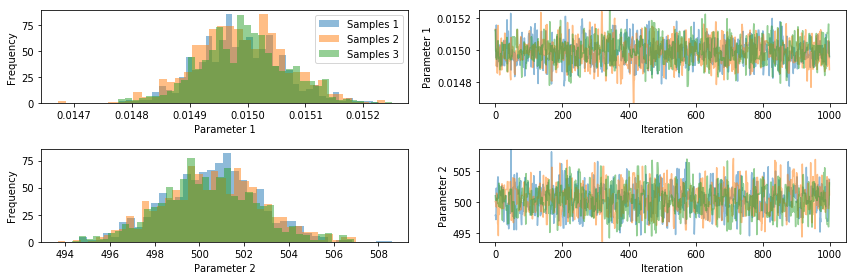

R-hat:
[1.000240049152296, 1.0005761749942765]


In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 450],
    [0.02, 560]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.01,
    real_parameters * 0.9,
    real_parameters * 1.1,
]

# Create mcmc routine
nuts_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.NoUTurnMCMC)
nuts_mcmc.set_max_iterations(2000)

# Set up modest logging
nuts_mcmc.set_log_to_screen(True)
nuts_mcmc.set_log_interval(100)

# Run!
print('Running...')
nuts_chains = nuts_mcmc.run()
print('Done!')

# Discard warm up
nuts_chains = nuts_chains[:, 1000:]

pints.plot.trace(nuts_chains)
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(nuts_chains))

We can do the same using Hamiltonian MCMC

Running...
Using Hamiltonian Monte Carlo
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     63     0.333     0.333     0          0:00.0
2     123    0.5       0.5       0          0:00.0
3     183    0.6       0.6       0          0:00.0
100   6003   0.98      0.951     0.931      0:00.5
200   12003  0.980198  0.975     0.965      0:01.0
300   18003  0.986755  0.98      0.974      0:01.5
400   24003  0.99      0.985     0.98       0:02.0
500   30003  0.988     0.988     0.984      0:02.4
600   36003  0.986711  0.99      0.985      0:02.9
700   42003  0.987     0.991453  0.985755   0:03.4
800   48003  0.989     0.993     0.988      0:03.9
900   54003  0.99      0.993     0.989      0:04.4
1000  60003  0.99002   0.993014  0.99002    0:04.8
1100  66003  0.991     0.993     0.991      0:05.3
1200  72003  0.992     0.993     0.991      0:05.8
1300  78003  0.992     0.994     0.992     

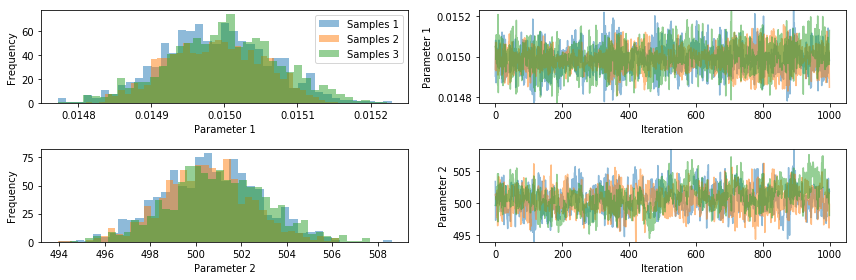

R-hat:
[1.0036299601714016, 1.0088776470723102]


In [3]:
# Create mcmc routine
h_mcmc = pints.MCMCController(log_posterior, len(xs), xs, method=pints.HamiltonianMCMC)
h_mcmc.set_max_iterations(2000)

# Set up modest logging
h_mcmc.set_log_to_screen(True)
h_mcmc.set_log_interval(100)

# Run!
print('Running...')
h_chains = h_mcmc.run()
print('Done!')

# Discard warm up
h_chains = h_chains[:, 1000:]

pints.plot.trace(h_chains)
plt.show()

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(h_chains))

Both samplers converge according to the R-hat measure, and both sets of chains are clearly mixing well and sampling the posterior correctly. However, the adaptive stepping in the NUTS sampler is resulting in an order of magnitude less function evaluations.

We can check the Estimated Sample Size (ESS) for both methods as well, which shows that NUTS also gives a more consistent ESS across the two parameters

In [4]:
# Check convergence using rhat criterion
print('NUTS Minimum ESS:')
print(np.min([pints.effective_sample_size(nuts_chains[i,:,:]) for i in range(nuts_chains.shape[0])],axis=0))
print('\nHamiltonian Minimum ESS:')
print(np.min([pints.effective_sample_size(h_chains[i,:,:]) for i in range(h_chains.shape[0])],axis=0))


NUTS Minimum ESS:
[219.61553808 206.80792093]

Hamiltonian Minimum ESS:
[333.33333333  15.956558  ]
